In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn as nn
import os
import zipfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_path = "/content/drive/MyDrive/DeepHeart/outputs_6leads.zip"
output_dir = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [4]:
class ECG_Data(Dataset):

    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        age = torch.tensor([int(self.df.iloc[index, 1])])
        sex = torch.tensor([0]) if self.df.iloc[index, 2] == 'Male' else torch.tensor([1])
        label = torch.tensor([int(self.df.iloc[index, 3])])

        file_name = "/content/outputs_6leads/" + self.df.iloc[index, 0] + ".csv"
        data = pd.read_csv(file_name)
        lead_data = data.iloc[:, 1:7].values.astype(float)
        windowed_lead_data = []
        for i in range(0, len(lead_data) - window_size + 1, window_size):              #windowing the lead data
              windowed_lead_data.append(lead_data[i:i+window_size])
        windowed_lead_data = torch.Tensor(windowed_lead_data)
        windowed_lead_data = torch.sum(windowed_lead_data, dim = 1)

        return windowed_lead_data, label, age, sex

In [5]:
df = pd.read_csv("/content/drive/MyDrive/DeepHeart/patients_outputs_6leads.csv")
df = df.dropna()

df_ones = df[df['Label'] == 1].copy()
df_zeros = df[df['Label'] == 0].sample(n=10000, random_state=42).copy()
df_final = pd.concat([df_ones, df_zeros])
df_final.reset_index(drop=True, inplace=True)

batch_size = 32
window_size = 250
ds = ECG_Data(df_final, window_size)

print(len(ds))
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = random_split(ds, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

18123


In [6]:
for data, label, age, sex in train_loader:
  print(data.size())
  print(age.size())
  print(label.size())
  print(sex.size())
  break

<ipython-input-4-e84a2e1281b1>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  windowed_lead_data = torch.Tensor(windowed_lead_data)


torch.Size([28, 40, 6])
torch.Size([28, 1])
torch.Size([28, 1])
torch.Size([28, 1])


In [73]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(Model,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.self_attention1 = nn.MultiheadAttention(hidden_size, num_heads = 64, batch_first = True)
        self.self_attention2 = nn.MultiheadAttention(hidden_size * 2, num_heads = 128, batch_first = True)

        self.att_up = nn.Linear(6, hidden_size)

        self.fc = nn.Sequential(nn.Linear(hidden_size * 2, 1000),
                                nn.Linear(1000, 2))

        self.sigmoid = nn.Sigmoid()

    def positional_encoding(self, var, size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, size, 2, device=self.device).float() / size)
        )
        pos_enc_a = torch.sin(var.repeat(1, size // 2) * inv_freq)
        pos_enc_b = torch.cos(var.repeat(1, size // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc


    def forward(self, lead_data, age, sex):
        batch_size = lead_data.size(0)

        lead_data = self.att_up(lead_data)
        attention_out,_ = self.self_attention1(lead_data,lead_data,lead_data)
        last_output = attention_out[:,-1,:]

        age = self.positional_encoding(age, 128)
        sex = self.positional_encoding(sex, 128)

        combined = torch.cat((last_output, age, sex), dim=1)
        combined, _ = self.self_attention2(combined, combined, combined)

        output = self.fc(combined)
        output = self.sigmoid(output)

        return output
input_size = 6
num_layers = 3
hidden_size = 256
model = Model(input_size,hidden_size,num_layers, device).to(device)

  0%|          | 1/518 [00:00<03:59,  2.16it/s]

EPOCH : 1/10, MIN_LOSS : 0.7040955424308777, LOSS : 0.7040955424308777


 19%|█▉        | 101/518 [00:51<03:26,  2.01it/s]

EPOCH : 1/10, MIN_LOSS : 0.5487600564956665, LOSS : 0.6819375157356262


 39%|███▉      | 201/518 [01:42<02:59,  1.77it/s]

EPOCH : 1/10, MIN_LOSS : 0.5314759016036987, LOSS : 0.808181643486023


 58%|█████▊    | 301/518 [02:32<02:21,  1.53it/s]

EPOCH : 1/10, MIN_LOSS : 0.5314759016036987, LOSS : 0.692251980304718


 77%|███████▋  | 401/518 [03:22<01:05,  1.79it/s]

EPOCH : 1/10, MIN_LOSS : 0.5252784490585327, LOSS : 0.7686324119567871


 97%|█████████▋| 501/518 [04:12<00:07,  2.15it/s]

EPOCH : 1/10, MIN_LOSS : 0.5252784490585327, LOSS : 0.7440366744995117


100%|██████████| 130/130 [00:51<00:00,  2.51it/s]


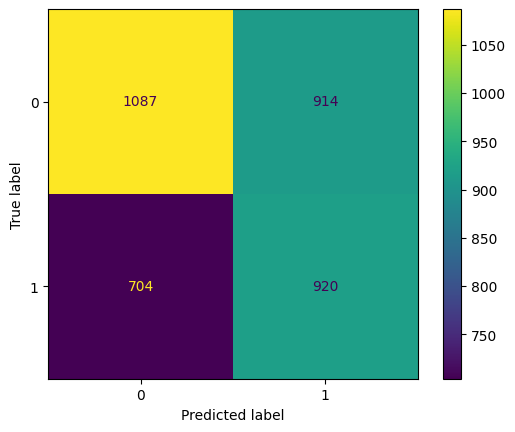

  0%|          | 1/518 [00:00<05:29,  1.57it/s]

EPOCH : 2/10, MIN_LOSS : 0.8657817840576172, LOSS : 0.8657817840576172


 19%|█▉        | 101/518 [00:48<03:27,  2.01it/s]

EPOCH : 2/10, MIN_LOSS : 0.5856314301490784, LOSS : 0.6817768216133118


 39%|███▉      | 201/518 [01:35<02:16,  2.33it/s]

EPOCH : 2/10, MIN_LOSS : 0.5622475743293762, LOSS : 0.6689276099205017


 58%|█████▊    | 301/518 [02:23<01:36,  2.25it/s]

EPOCH : 2/10, MIN_LOSS : 0.5622475743293762, LOSS : 0.7016177177429199


 77%|███████▋  | 401/518 [03:14<01:37,  1.20it/s]

EPOCH : 2/10, MIN_LOSS : 0.5602672696113586, LOSS : 0.7165563702583313


 97%|█████████▋| 501/518 [04:06<00:08,  1.91it/s]

EPOCH : 2/10, MIN_LOSS : 0.556384265422821, LOSS : 0.7034252285957336


100%|██████████| 130/130 [00:56<00:00,  2.32it/s]


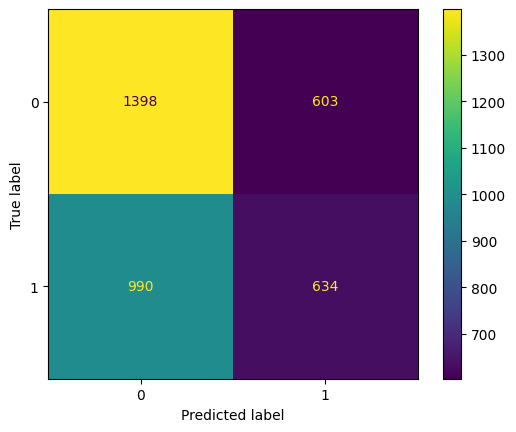

  0%|          | 1/518 [00:00<04:01,  2.14it/s]

EPOCH : 3/10, MIN_LOSS : 0.7027899622917175, LOSS : 0.7027899622917175


  4%|▎         | 19/518 [00:09<04:46,  1.74it/s]

In [ ]:
val_losses = []
train_losses = []
epochs = 10
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005)

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    min_loss = 1000.0


    model.train()
    for i, (lead_data, labels, age, sex) in enumerate(tqdm(train_loader)):

        lead_data = lead_data.to(device)
        age = age.to(device)
        sex = sex.to(device)

        labels = F.one_hot(labels, num_classes=2)
        labels = labels.type(torch.FloatTensor)
        labels = labels.squeeze()
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(lead_data, age, sex)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * lead_data.size(0)
        if loss.item() < min_loss:
          min_loss = loss.item()
        if i % 100 == 0:
          print("EPOCH : {}/{}, MIN_LOSS : {}, LOSS : {}".format(epoch + 1, epochs, min_loss, loss.item()))

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)



    # Validation
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for lead_data, labels, age, sex in tqdm(test_loader):
            lead_data = lead_data.to(device)
            age = age.to(device)
            sex = sex.to(device)

            outputs = model(lead_data, age, sex)
            _, predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                label = labels[i]
                pred = predicted[i]
                predictions.append(pred.item())
                actual.append(label.item())
        cm = confusion_matrix(actual, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot()
        plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/DeepHeart.pth")